# Libraries

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta, date, datetime

## Problem Details

In [2]:
## TODO: აქ ჩამოვწერთ, რასაც გადავწყვეტთ რომ უნდა გადავჭრათ

## Steps:
### 1. Exploring Data

### 1. Data analysis

First, Let's find out what our data actually contains.

In [3]:
data = pd.read_csv("Local/mfp-diaries.tsv", sep='\t', header=None, names=["user_id", "diary_date", "food_list", "daily_intake_and_goal"])

### Observation

In [4]:
data.head()

,user_id,diary_date,food_list,daily_intake_and_goal
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [5]:
print(data['user_id'].dtype)
print(data['diary_date'].dtype)
print(data['food_list'].dtype)
print(data['daily_intake_and_goal'].dtype)

int64
object
object
object


We can see that our data has 4 columns.
First is user_id: user identifier - integer.
Second is diary_date: entry date of information - string (object in Pandas’ world is string (text)).
Third is food_list: For each entry it has meal name and its content (nutrients, calories da etc.) - string.
Fourth is daily_intake_and_goal: user's goal calories and nutrients.

Number of its' features and variables

In [6]:
data.shape

(587187, 4)

Quickly checking if there are some duplicated rows in our data, because we don't need excessive information

In [7]:
print(f"Duplicated rows: {data.duplicated().sum()}")

Duplicated rows: 0


Good, there was none.
Now we need to check if there are any missing values in our data. Because later on it may cause problems (For example, if we decide to use K-means clustering; it can't handle missing values).

In [8]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
user_id                  0
diary_date               0
food_list                0
daily_intake_and_goal    0
dtype: int64


Fortunatelly, neither missing values are in our data.

It would be interesting to know in what time range was our data formed.

In [9]:
start_date = data[data.columns[1]].unique().min()
final_date = data[data.columns[1]].unique().max()
print("Start Date: ", start_date)
print("Final Date: ", final_date)

Start Date:  2014-09-14
Final Date:  2015-04-09


So, it seems like our nearly 590k input was submitted in less than a year.
Now let's see how many distinct dates we have, it should be important later on to consider how consistent users actually were while submitting their data.


In [10]:
print("Distinct Dates: ", len(data[data.columns[1]].unique()))

Distinct Dates:  208


Okay, it turns out that there are no duplicated dates, because 208 is literally number of days between Start and Final Dates.
But it's interesting to know, if user's were equally excited to submit their data during these 208 days? Let's find out. 

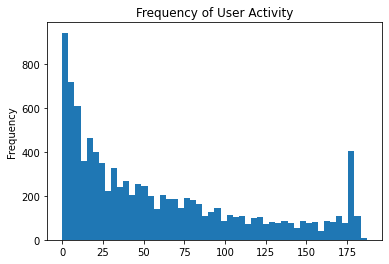

In [11]:
start = datetime.strptime(str(start_date),'%Y-%m-%d').date()
final = datetime.strptime(str(final_date),'%Y-%m-%d').date()
activity = np.zeros(data[data.columns[0]].unique().max())
for i in range(int((final - start).days) + 1):
    curr_date = start + timedelta(i)
    curr_date_string = curr_date.strftime('%Y-%m-%d')
    curr_date = data[data[data.columns[1]] == curr_date_string]
    for j in range(curr_date.shape[0]):
        activity[curr_date.iloc[j,0]-1]+=1

plt.hist(activity, bins=50)
plt.ylabel('Frequency')
plt.title('Frequency of User Activity')
plt.show()

As we can see, at the begining of our start date users' activity was quite high. But it drastically continued dropping, but at some point at the end, activity has grown again. This may be related to app's popularity in general (for example, let's suppose that loyal users were submmiting data all along, but when this application was advertised some other random poeple also got interested, but their activity was not consistent).

In particular, at some point, very popular sports brand "Under Armour" actively started buying sports apps and in feburary 4th of 2015 it also acquired MyFitnessPal, the app behind the data we're handling. This is consistent with the growth in the graph above, though it seems like this popularity didn't last long for MyFitnessPal. Right now Under Armour is selling MyFitnessPal for 130 million dollars less than it initialy bought it.

Now, let's quickly observe actual food input and its content. As I said above, every food input has its content. let's have a quick look on that.

In [12]:
food_entries = json.loads(data.iloc[0, 2])
print(food_entries)

[{'meal': 'MY food', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '412'}, {'name': 'Carbs', 'value': '29'}, {'name': 'Fat', 'value': '24'}, {'name': 'Protein', 'value': '21'}, {'name': 'Sodium', 'value': '258'}, {'name': 'Sugar', 'value': '29'}], 'name': 'my - McDonalds Espresso Pronto® Flat White, 2 TALL'}, {'nutritions': [{'name': 'Calories', 'value': '170'}, {'name': 'Carbs', 'value': '25'}, {'name': 'Fat', 'value': '5'}, {'name': 'Protein', 'value': '20'}, {'name': 'Sodium', 'value': '260'}, {'name': 'Sugar', 'value': '2'}], 'name': 'Quest Bar - Banana Nut Muffin Natural Protein Bar, 60 g'}, {'nutritions': [{'name': 'Calories', 'value': '176'}, {'name': 'Carbs', 'value': '33'}, {'name': 'Fat', 'value': '1'}, {'name': 'Protein', 'value': '5'}, {'name': 'Sodium', 'value': '195'}, {'name': 'Sugar', 'value': '0'}], 'name': 'Uncle Tobys Australia - Vita Brits, 3 Biscuits 33.3g'}, {'nutritions': [{'name': 'Calories', 'value': '342'}, {'name': 'Carbs', 'value': '34'}, {'name':

as we can see, each input (above was just first and random example) has nutrients, which on its side has name and corresponding value. Let's find out how many distinct nutrients are in our data.

In [13]:
distinct_nutritions = {}
for i in range(data.shape[0]):
    food_input = json.loads(data.iloc[i,2])
    for j in range(len(food_input)):
        dishes = food_input[j]['dishes']
        for dish in range(len(dishes)):
            nutritions = dishes[dish]['nutritions']
            for nutrient in range(len(nutritions)):
                nutrient_name = nutritions[nutrient]['name']
                if nutrient_name in distinct_nutritions.keys():  # if already encountered
                    distinct_nutritions[nutrient_name] += 1
                else:
                    distinct_nutritions[nutrient_name] = 1
                    
print(distinct_nutritions.keys())
number_of_distinct_nutrients = len(distinct_nutritions.keys())
print("Number of Distinct Nutrients in our data: " + str(number_of_distinct_nutrients))

dict_keys(['Calories', 'Carbs', 'Fat', 'Protein', 'Sodium', 'Sugar', 'Fiber', 'Potass.', 'Iron', 'Calcium', 'Sat Fat', 'Chol', 'Vit A', 'Vit C', 'Trn Fat', 'Mon Fat', 'Ply Fat'])
Number of Distinct Nutrients in our data: 17


turns out that we have 17 unique nutrient inputs. let's see their distribution.

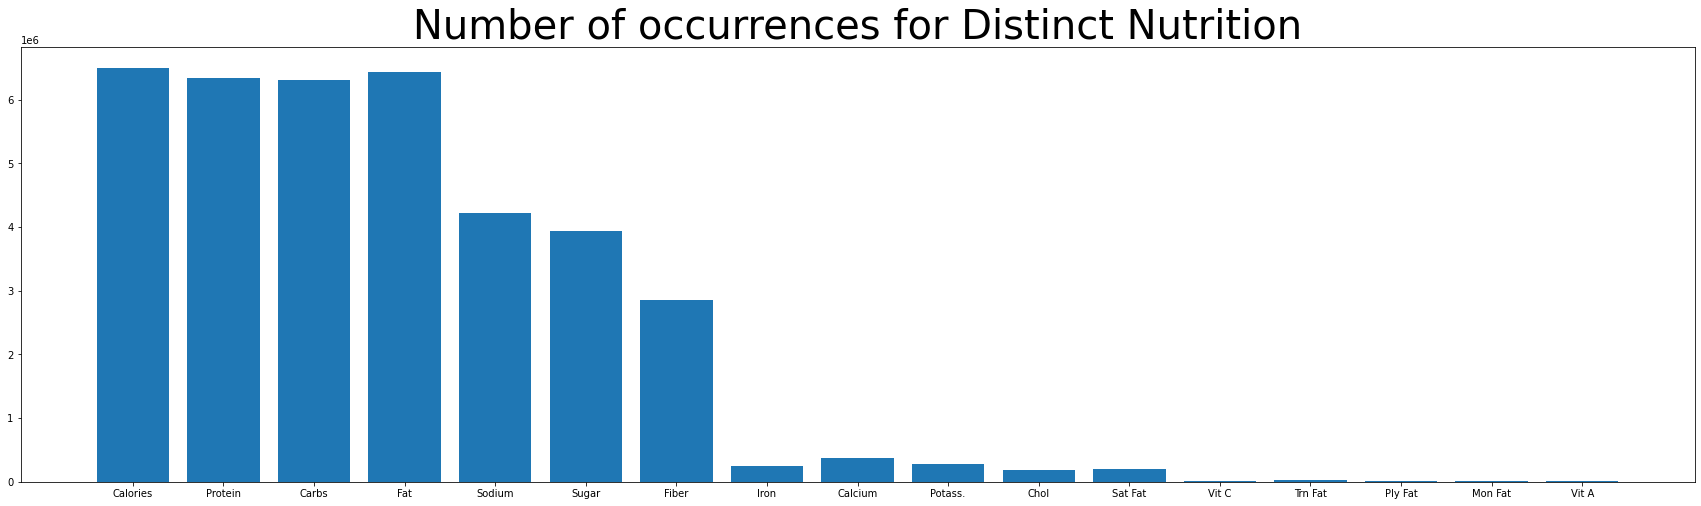

In [14]:
nutrients = sorted(distinct_nutritions.items(), key=lambda x : x[1], reverse = True)
keys = {}
for nutrient in nutrients:
    keys[nutrient[0]] = nutrient[1]
plt.figure(figsize = (30,8))
plt.bar(x = keys.keys(), height = distinct_nutritions.values())
plt.title('Number of occurrences for Distinct Nutrition', size=40)
plt.show()

Most 'popular' nutrients are obviously calories, protein, carbs and fat.  Medium popular are Sodium sugar and fiber. Rest of them are extremely rare. let's not consider them for now and see distribution within popular (or not so popular) ones.

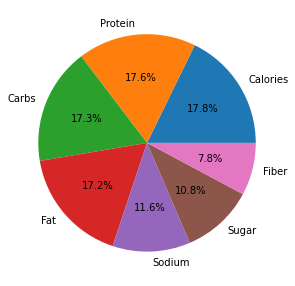

In [15]:
populars = {}
unpopulars =['Vit A', 'Vit C', 'Trn Fat', 'Potass.',
                    'Mon Fat', 'Ply Fat','Iron','Calcium','Chol','Sat Fat']
for nutrient_name in keys.keys():
    if nutrient_name not in unpopulars:
        populars[nutrient_name] = keys[nutrient_name]

plt.figure(figsize=(10,5))
plt.pie(populars.values(), labels = populars.keys(), autopct = "%1.1f%%")
plt.show()

##### Little observations that we don't want to ignore

We explored some random columns (as much as we thought was nearly enough) and found out that some not so pleasant :) users have ruined statistics. For example, they didn't submit data fully, their daily meals doesn't contain 3 or 4 meals. Maybe that's seperate statistics itself and we can conclude that these kind of users are busy and don't have time to either:
1. use this app every day consistently
2. to eat (even sadder);
in either assumptions we thought that this case was worth to take into consideration.

It's also frustraiting that every food name has coressponding amount of it, but it is not consistent unfortunatelly. In our mind, this will cause some obstacles. For instance, some food is described in grams, others in mililiters or cups or sticks. This will for sure make our task harder (and maybe a little ambiguous too).

# Sample row for convenience

In [16]:
user_id = data.iloc[1006,0]
date = data.iloc[1006,1]
food_entries = json.loads(data.iloc[1006, 2])
agregate_intake_goal = json.loads(data.iloc[1006,3])
print(food_entries)

[{'meal': 'Breakfast', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '100'}, {'name': 'Carbs', 'value': '11'}, {'name': 'Fat', 'value': '0'}, {'name': 'Protein', 'value': '13'}, {'name': 'Sodium', 'value': '55'}, {'name': 'Sugar', 'value': '7'}], 'name': 'Yoplait - Greek 100 Calories Vanilla, 150 g'}], 'sequence': 1}, {'meal': 'Lunch', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '360'}, {'name': 'Carbs', 'value': '30'}, {'name': 'Fat', 'value': '18'}, {'name': 'Protein', 'value': '15'}, {'name': 'Sodium', 'value': '690'}, {'name': 'Sugar', 'value': '3'}], 'name': 'Alexia - Mozzarella Stix, 6 stix'}, {'nutritions': [{'name': 'Calories', 'value': '17'}, {'name': 'Carbs', 'value': '0'}, {'name': 'Fat', 'value': '0'}, {'name': 'Protein', 'value': '4'}, {'name': 'Sodium', 'value': '55'}, {'name': 'Sugar', 'value': '0'}], 'name': 'Home Cooked - 2 Hard Boiled Egg Whites, 1 hard boiled eggs'}], 'sequence': 2}, {'meal': 'Snacks', 'dishes': [{'nutritions': [{'name': 'Calo

# Data parsing

Let's start actual Data parsing. below block of code is simple initialization of nutrients.

In [17]:
altered_data = {}

def init_nutrients(user):
    user["calories"] = {}
    user["carbs"] = {}
    user["sugar"] = {}
    user["fat"] = {}
    user["protein"] = {}
    user["goal_calories"] = {}
    user["goal_carbs"] = {}
    user["goal_sugar"] = {}
    user["goal_fat"] = {}
    user["goal_protein"] = {}

#### Methotds

Actually adding nutrients to above initilized dictionaries. Also, want to point out that we don't consider entry valid if there is no calories in it. Because such information is trush for our future intentions.

In [18]:
def add_nutrients(user, agregate_intake_goal, date):
    calories_filled = False
    goal_calories_filled = False
    for i in range(len(agregate_intake_goal["total"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            calories_filled = True
    for i in range(len(agregate_intake_goal["goal"])):
            if agregate_intake_goal["goal"][i]["name"] == "Calories":
                goal_calories_filled = True

    if calories_filled and goal_calories_filled:
        for i in range(len(agregate_intake_goal["total"])):
            if agregate_intake_goal["total"][i]["name"] == "Calories":
                user["calories"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Carbs":
                user["carbs"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Sugar":
                user["sugar"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Fat":
                user["fat"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Protein":
                user["protein"][date] = agregate_intake_goal["total"][i]["value"]

        for i in range(len(agregate_intake_goal["goal"])):
            if agregate_intake_goal["goal"][i]["name"] == "Calories":
                user["goal_calories"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Carbs":
                user["goal_carbs"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Sugar":
                user["goal_sugar"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Fat":
                user["goal_fat"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Protein":
                user["goal_protein"][date] = agregate_intake_goal["goal"][i]["value"]
        return True
    else:
        return False

adding calories to corresponding month

In [19]:
def add_calories_to_month(month, agregate_intake_goal, user):
    for i in range(len(agregate_intake_goal["total"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            user[month]["calories"] += agregate_intake_goal["total"][i]["value"]
    user[month]["days"] += 1

simple initialization of month dictionary.

In [20]:
def init_month(user, date, month):
    user[month] = {}
    user[month]["date"] = date[5:7] + "/" + date[0:4]
    user[month]["days"] = 0
    user[month]["calories"] = 0

In [21]:
for i in range(int(len(data))):
    # read i-th row
    user_id = data.iloc[i,0]
    date = data.iloc[i,1]
    food_entries = json.loads(data.iloc[i, 2])
    agregate_intake_goal = json.loads(data.iloc[i,3])

    if user_id not in altered_data:
        altered_data[user_id] = {}
        altered_data[user_id]["first_entry_date"] = date
        altered_data[user_id]["active_days"] = 0
        altered_data[user_id]["food"] = {}
        altered_data[user_id]["food_count"] = 0
        init_nutrients(altered_data[user_id])
        init_month(altered_data[user_id], date, "first_month")
        init_month(altered_data[user_id], date, "last_month")

    if add_nutrients(altered_data[user_id], agregate_intake_goal, date):
        altered_data[user_id]["last_entry_date"] = date
        altered_data[user_id]["active_days"] += 1
    else:
        continue

    if altered_data[user_id]["first_month"]["date"] == date[5:7] + "/" + date[0:4]:
        add_calories_to_month("first_month", agregate_intake_goal, altered_data[user_id])
    else:
        if altered_data[user_id]["last_month"]["date"] != date[5:7] + "/" + date[0:4]:
            init_month(altered_data[user_id], date, "last_month")
        add_calories_to_month("last_month", agregate_intake_goal, altered_data[user_id])

    for meal in food_entries:
        for dish in meal["dishes"]:
            food_name = dish["name"][0:dish["name"].index(',')]
            if food_name != "Quick Added Calories":
                if food_name not in altered_data[user_id]["food"]:
                    altered_data[user_id]["food"][food_name] = {}
                    altered_data[user_id]["food"][food_name]["count"] = 0  
                    altered_data[user_id]["food"][food_name]["nutrients"] = dish["nutritions"]
                altered_data[user_id]["food"][food_name]["count"] += 1
                altered_data[user_id]["food_count"] += 1

## Sample data visualization

For the given user, sets a new value describing the amount
of days from first data entry to (including) the last one. We considered user's active period based on his first and last input date individually (not based on general first/last in out data). 

In [22]:
def calculate_days(user):
    first_year = int(user["first_entry_date"][:4])
    first_month = int(user["first_entry_date"][5:7])
    first_day = int(user["first_entry_date"][8:])
    last_year = int(user["last_entry_date"][:4])
    last_month = int(user["last_entry_date"][5:7])
    last_day = int(user["last_entry_date"][8:])
    f_date = datetime(first_year, first_month, first_day)
    l_date = datetime(last_year, last_month, last_day)
    delta = l_date - f_date
    user["days"] = delta.days + 1

Function for sorting food according to it's consumption frequency

In [23]:
def food_sort(key):
    return -food[key]["count"]
# Total amount of users
print("Total users:", len(altered_data.keys()))

Total users: 9896


Take sample user for closer look and visualization (2, 5 - sugars instead of carbs, 8 - no carbon, no sugar, no fat, 689 - number of calories). We chose to have sample user for observation purposes. By observing on sample users, it might help us to decide what variables to use later on.

In [24]:
inputs doens't match number of goal_calories inputs)
sample_user = altered_data[2]
food = sample_user["food"]

# User activity: active days from all days since first app usage
calculate_days(sample_user)
print("User activity", sample_user["active_days"], "/", sample_user["days"])

User activity 60 / 60


Print top ten frequently consumed dishes

In [26]:
food_list = [key for key in food.keys()]
food_list.sort(key=food_sort)
print("Top ten frequent dishes")
for i in range(10):
    print("\t" + food_list[i])

	Nescafe - Decaf Coffee With Skimmed Milk
	Sugars - Granulated (sucrose)
	Warburton's - Wholemeal Bread 800g
	Generic - Wholemeal Bread-One Slice
	Nescafe - Double Choca Mocha Uk
	Quorn - Chicken Style Fillet
	Marmite - Marmite
	Bisto Best - Caramelised Onion Gravy
	Quorn - Nugget
	Walkers - Cheese and Onion Crisp


Formats date vertically so that it can be more compact and easier to read

In [27]:
def vertical_date(date):
    return date[8:] + '\n' + date[5:7] + '\n' + date[2:4]

Formatter function for pie chart magnitudes

In [55]:
def filter_value(val):
    if (val < 5):
        return ""
    return '{:.2f}%\n({:.0f})'.format(val, sample_user["food_count"] * val / 100)

Plots given nutrient (or calories) distribution throughout app usage.

In [29]:
def plot_nutrients(nutrient, name):
    f = plt.figure() 
    f.set_figwidth(20)
    f.set_figheight(6)
    plt.plot([vertical_date(key) for key in sample_user[nutrient].keys()], [value for value in sample_user[nutrient].values()], marker='o')
    plt.plot([vertical_date(key) for key in sample_user["goal_" + nutrient].keys()], [value for value in sample_user["goal_" + nutrient].values()], marker='o')
    plt.title("Taken " + nutrient + " vs goal " + nutrient)
    plt.xlabel("Days")
    plt.ylabel(name)
    plt.legend(["Taken", "Goal"])
    plt.show()

Label creation for food pie chart

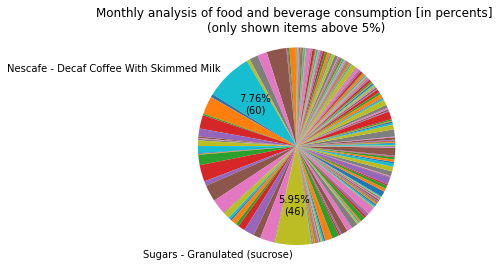

In [30]:
labels = []
for key in food.keys():
    if food[key]["count"] / sample_user["food_count"] < 0.05:
        labels.append("")
    else:
        labels.append(key)

magnitudes = [food[key]["count"] for key in food.keys()]
# Food frequency consumption pie chart
fig1, ax1 = plt.subplots()
ax1.pie(magnitudes, labels=labels, autopct=filter_value, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Monthly analysis of food and beverage consumption [in percents] \n(only shown items above 5%)")
plt.show()

The reason why this pie chart is so chaotic is that nothing (expect one food) was consumed more than 5% of people. This can have two explenations. Either pople registered on this app have very different taste or same products are described with slightly different title. But as we have researched, we found out that, there are default names for product to enter. So, we assume that people on this app have extremely different taste.

Nutrient and calories distribution plots

Average calories per day: 1457.1666666666667


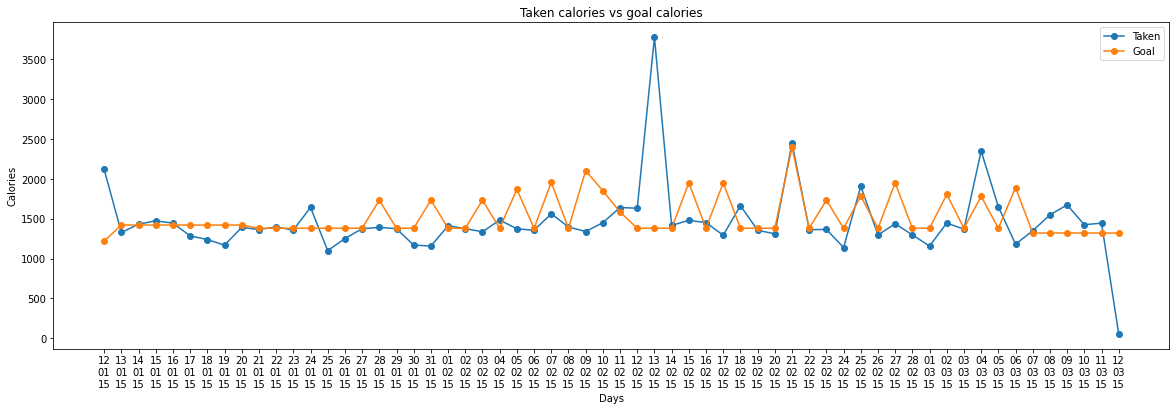

In [31]:
print("Average calories per day:", stats.mean(sample_user["calories"].values()))
plot_nutrients("calories", "Calories")

We thought that this was good example for visualization because for naked eye its very easy to see user's goal compared to his/her actual taken calories.

Average carbs per day: 181.2


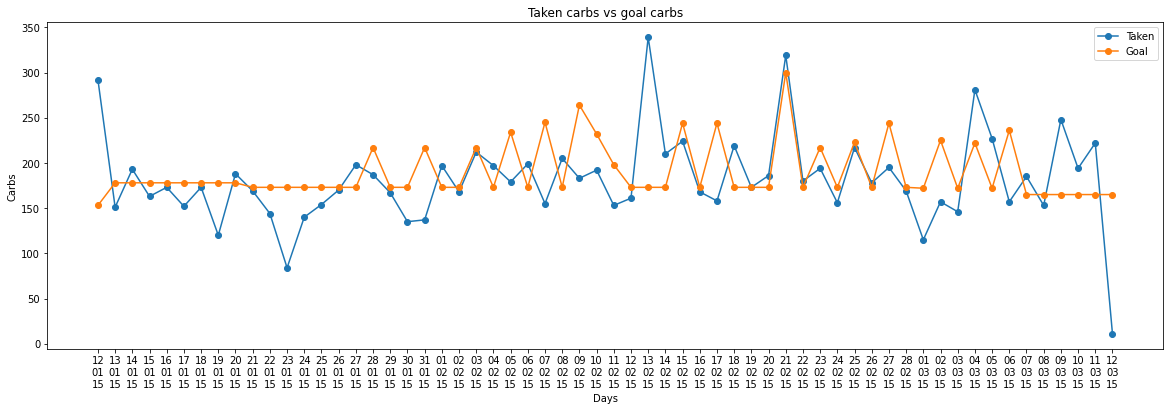

Average fat per day: 42.28333333333333


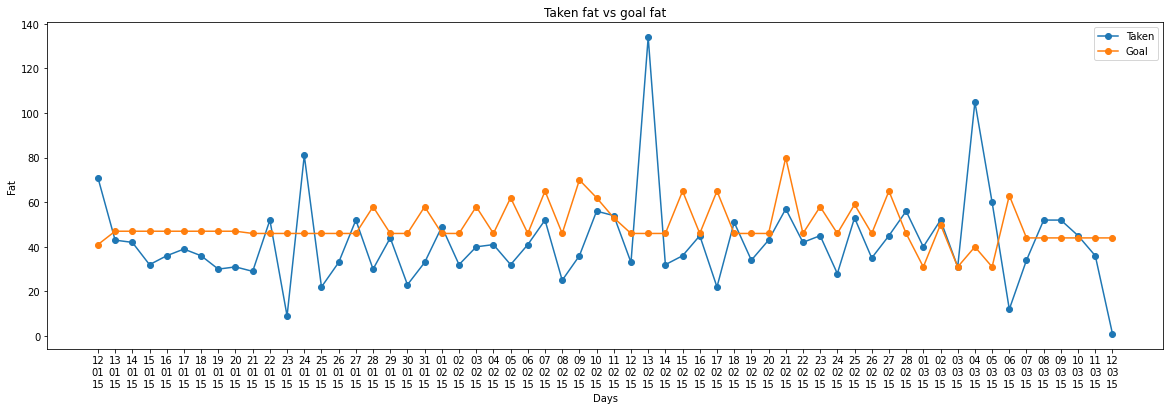

Average protein per day: 42.5


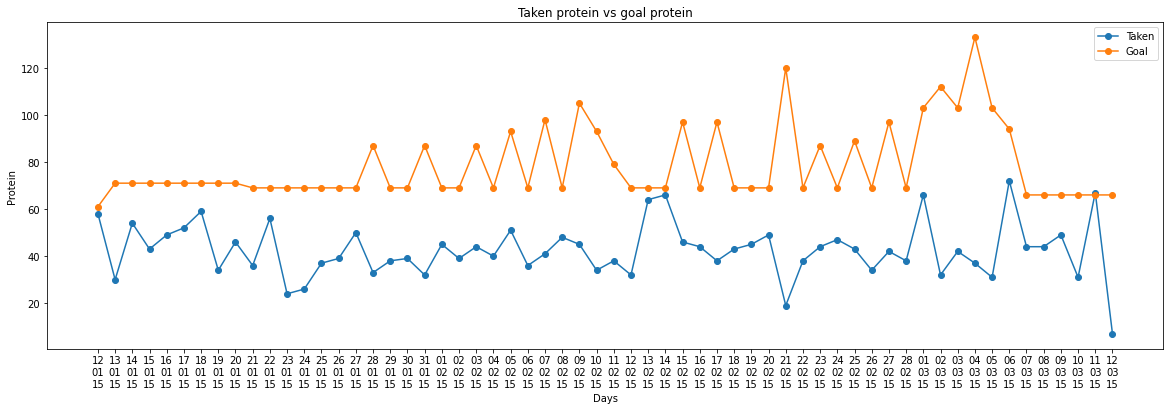

In [32]:
if len(sample_user["carbs"]) == 0:
    if len(sample_user["sugar"]) == 0:
        print("Average carbs per day: 0")
    else:
        print("Average carbs per day:", stats.mean(sample_user["sugar"].values()))
    plot_nutrients("sugar", "Sugar")
else:
    print("Average carbs per day:", stats.mean(sample_user["carbs"].values()))
    plot_nutrients("carbs", "Carbs")

if len(sample_user["fat"]) == 0:
    print("Average fat per day: 0")
else:
    print("Average fat per day:", stats.mean(sample_user["fat"].values()))
plot_nutrients("fat", "Fat")

if len(sample_user["fat"]) == 0:
    print("Average protein per day: 0")
else:
    print("Average protein per day:", stats.mean(sample_user["protein"].values()))

plot_nutrients("protein", "Protein")


In [33]:
print("First month and cumulative consumed calories:", sample_user["first_month"])
print("Last month and cumulative consumed calories:", sample_user["last_month"])

First month and cumulative consumed calories: {'date': '01/2015', 'days': 20, 'calories': 27445}
Last month and cumulative consumed calories: {'date': '03/2015', 'days': 12, 'calories': 16641}


## Insert prepared data to a pandas dataframe for further ML analysis

In [34]:
final_dict = {}
final_dict["user_activity"] = []
final_dict["average_calories_per_day"] = []
final_dict["average_carbs_per_day"] = []
final_dict["average_fat_per_day"] = []
final_dict["average_protein_per_day"] = []

Only taking what portion of food's energetic value these macronutrients make 
describes user's favourite food's nature more and is not likely to cause
unnecessary differentiation between users
In my opinion, this may be a problem when taking raw nutrients instead. Also, we thought that to compare we won't use weight metrics, because it might be a little bit (or not more) inaccurate. Instead we will use percentages to compare.

In [56]:
final_dict["favourite_food_carbs_part"] = []
final_dict["favourite_food_fat_part"] = []
final_dict["favourite_food_protein_part"] = []

goal_taken_calories_error: Taking taken and goal error of other nutrients may be better than including favourite food, but we'll try this for now. This will help us to track how user actually pursues his/her goals.

overal_calories_consumption_change: user's last active month average divided by first active month average. In some cases this might be a little bit misleading (for example, if in either month's activity was only several days; But we thought that it was best option).

In [58]:
# Taking taken and goal error of other nutrients may be better than
# including favourite food, but we'll try this for now
final_dict["goal_taken_calories_error"] = []
final_dict["overal_calories_consumption_change"] = []

In [37]:
keys = [key for key in altered_data.keys()]
for i in range(len(keys)):
    current_user = altered_data[keys[i]]

    # Dismissing users with at most month-long activity
    if current_user["active_days"] < 30 or current_user["first_month"]["date"] == current_user["last_month"]["date"]:
        continue
    food = current_user["food"]

    calculate_days(current_user)
    final_dict["user_activity"].append(current_user["active_days"] / current_user["days"])


    final_dict["average_calories_per_day"].append(stats.mean(current_user["calories"].values()))
    if len(current_user["carbs"]) == 0 and len(current_user["sugar"]) != 0:
        final_dict["average_carbs_per_day"].append(stats.mean(current_user["sugar"].values()))
    else:
        if len(current_user["carbs"]) == 0:
            final_dict["average_carbs_per_day"].append(0)
        else:
            final_dict["average_carbs_per_day"].append(stats.mean(current_user["carbs"].values()))
    
    if len(current_user["fat"]) == 0:
        final_dict["average_fat_per_day"].append(0)
    else:
        final_dict["average_fat_per_day"].append(stats.mean(current_user["fat"].values()))
    
    if len(current_user["protein"]) == 0:
        final_dict["average_protein_per_day"].append(0)
    else:
        final_dict["average_protein_per_day"].append(stats.mean(current_user["protein"].values()))

    fav_food = [key for key in food.keys()]
    fav_food.sort(key=food_sort)
    fav_food = food[fav_food[0]]
    fav_carbs = None
    fav_sugar = None
    fav_fat = None
    fav_proteins = None
    for nutrient in fav_food["nutrients"]:
        if nutrient["name"] == "Carbs":
            fav_carbs = int(nutrient["value"])
        if nutrient["name"] == "Sugar":
            fav_sugar = int(nutrient["value"])
        if nutrient["name"] == "Fat":
            fav_fat = int(nutrient["value"])
        if nutrient["name"] == "Protein":
            fav_proteins = int(nutrient["value"])
    if fav_carbs == None:
        if fav_sugar != None:
            fav_carbs = fav_sugar
        else:
            fav_carbs = 0
    if fav_fat == None:
        fav_fat = 0
    if fav_proteins == None:
        fav_proteins = 0
    fav_sum = fav_carbs + fav_fat + fav_proteins
    if fav_sum == 0:
        fav_sum = 1
    final_dict["favourite_food_carbs_part"].append(fav_carbs / fav_sum)
    final_dict["favourite_food_fat_part"].append(fav_fat / fav_sum)
    final_dict["favourite_food_protein_part"].append(fav_proteins / fav_sum)

    calories = [value for value in current_user["calories"].values()]
    goal_calories = [value for value in current_user["goal_calories"].values()]
    final_dict["goal_taken_calories_error"].append(mean_squared_error(goal_calories, calories))

    first_avg_cal = current_user["first_month"]["calories"] / current_user["first_month"]["days"]
    last_avg_cal = current_user["last_month"]["calories"] / current_user["last_month"]["days"]
    final_dict["overal_calories_consumption_change"].append(last_avg_cal / first_avg_cal)

final_data = pd.DataFrame(final_dict)
final_data.head()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
0,0.966667,2308.908046,185.431034,77.942529,128.781609,0.391892,0.324324,0.283784,305237.051724,1.119999
1,1.000000,1457.166667,181.200000,42.283333,42.500000,0.607143,0.035714,0.357143,213693.716667,1.010567
2,1.000000,2997.938547,121.268156,77.195531,188.379888,0.478261,0.130435,0.391304,290405.368715,0.930052
3,0.646067,1357.026087,141.295652,54.495652,67.347826,0.000000,0.000000,1.000000,222755.060870,1.345699
4,0.480226,1975.200000,0.000000,0.000000,128.600000,0.000000,0.000000,1.000000,169168.905882,0.426522


# Clustering

**Scaling**

Scaling data using sklearn library

In [38]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data)
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03
mean,9.696100e-17,4.009615e-17,5.775143e-17,-9.662734e-17,7.119308e-17,-4.964830e-17,2.394330e-16,-9.498765e-17,-5.296820e-18,-2.508750e-17
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-1.816097e+00,-2.447257e+00,-2.120053e+00,-1.644895e+00,-2.073509e+00,-1.066419e+00,-6.384333e-01,-8.275168e-01,-2.192917e-02,-5.621626e-02
25%,-8.962825e-01,-5.719936e-01,-5.134949e-01,-4.271939e-01,-5.759274e-01,-1.066419e+00,-6.384333e-01,-8.275168e-01,-2.098382e-02,-3.113962e-02
50%,-2.502189e-02,-1.222154e-01,-1.913380e-02,-7.849361e-02,-1.746288e-01,-6.402749e-02,-5.793906e-01,-4.158702e-01,-2.030825e-02,-2.507093e-02
75%,1.007386e+00,4.364276e-01,4.779793e-01,3.379710e-01,3.869235e-01,9.644002e-01,2.914896e-01,5.157511e-01,-1.908364e-02,-1.805608e-02
max,1.368784e+00,2.864087e+01,3.725916e+01,4.993560e+01,2.328413e+01,1.511159e+00,3.081258e+00,2.362744e+00,6.877636e+01,7.408856e+01


Rational number of clusters should be between 2 to 10 by considering data's context interpretation possibilities as well as ease of handling afterwards 

**Inferring appropriate number of clusters using elbow method**

Storing sum of squared errors for each iteration for 2 to 10 clusters

In [39]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)
    sse.append(kmeans.inertia_)

Plotting sums of squared errors

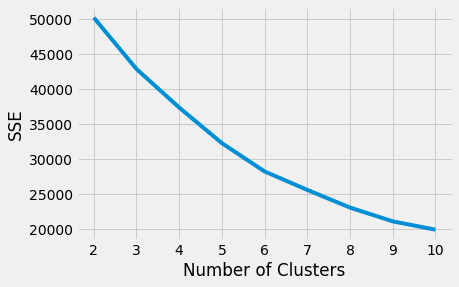

In [40]:
plt.style.use('fivethirtyeight')
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Elbow doesn't make it very clear but, most of all, 6 seems to be the best number of clusters for our data

**Inferring appropriate number of clusters according to silhouette coefficients**

Storing silhouette coefficients for each iteration for 2 to 10 clusters

In [41]:
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_coefficients.append(score)

Plotting silhouette coefficient distribution

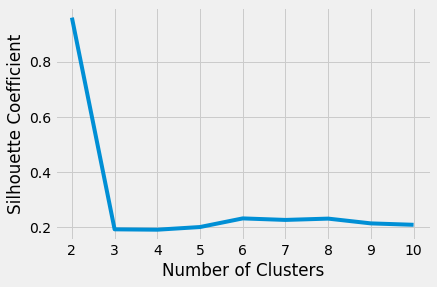

In [42]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Silhouette coefficient method shows more comprehensible data and clearly 5 is the winner for number of clusters

**Both results still somewhat agree, but we choose 6 as a more clear candidate for the number of clusters**

## Final run of kmeans to store correct clusters

In [43]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)

## Let's try shrinking data to 2 dimensions for possible better visual comprehension of clusters

In [44]:
reduced_data = PCA(n_components=2).fit_transform(scaled_data)

**Plotting dimension reduced data**

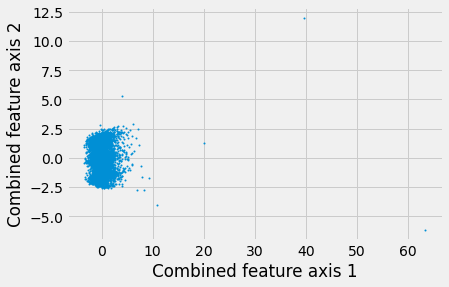

In [45]:
reduced_data_x = reduced_data[:, 0]
reduced_data_y = reduced_data[:, 1]
plt.scatter(reduced_data_x, reduced_data_y, marker='o', s=1, linewidths=1)
plt.xlabel("Combined feature axis 1")
plt.ylabel("Combined feature axis 2")
plt.show()

**Showing result clusters on reduced dimensions is not going to be useful as no distinguishable clusters are visible to naked eyes**

## Analysing each cluster

In [46]:
corresponding_clusters = kmeans.predict(scaled_data).tolist()
final_data['cluster'] = corresponding_clusters
final_data.head()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change,cluster
0,0.966667,2308.908046,185.431034,77.942529,128.781609,0.391892,0.324324,0.283784,305237.051724,1.119999,1
1,1.000000,1457.166667,181.200000,42.283333,42.500000,0.607143,0.035714,0.357143,213693.716667,1.010567,4
2,1.000000,2997.938547,121.268156,77.195531,188.379888,0.478261,0.130435,0.391304,290405.368715,0.930052,1
3,0.646067,1357.026087,141.295652,54.495652,67.347826,0.000000,0.000000,1.000000,222755.060870,1.345699,0
4,0.480226,1975.200000,0.000000,0.000000,128.600000,0.000000,0.000000,1.000000,169168.905882,0.426522,0


In [47]:
clusters = []
for i in range(5):
    clusters.append(final_data.loc[final_data['cluster'] == i])
    del clusters[i]['cluster']

**First cluster description**

In [48]:
clusters[0].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,8.370000e+02,837.000000
mean,0.632840,1342.158627,124.348031,47.159169,81.867838,0.071415,0.056594,0.871991,5.807475e+05,1.537625
std,0.259918,333.288025,50.308768,19.609656,32.151999,0.115260,0.093147,0.152603,5.342710e+05,10.341434
min,0.167598,300.112360,0.000000,0.000000,18.800000,0.000000,0.000000,0.416667,5.305294e+03,0.060004
25%,0.407407,1112.938053,93.016949,36.645714,58.880000,0.000000,0.000000,0.769231,2.396533e+05,0.806142
50%,0.613333,1345.721739,127.472727,46.978947,76.256410,0.000000,0.000000,0.933333,4.169456e+05,0.983016
75%,0.894737,1555.608108,156.597765,58.500000,98.446429,0.125000,0.076923,1.000000,7.070793e+05,1.200127
max,1.000000,2968.177778,298.985714,137.132812,293.805556,0.500000,0.416667,1.000000,4.314290e+06,298.402778


**Second cluster description**

In [49]:
clusters[1].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1.085000e+03,1085.000000
mean,0.815920,1960.007220,206.160896,72.111018,105.181517,0.495273,0.112989,0.192659,1.077242e+07,1.069509
std,0.217392,502.747274,93.051924,28.188389,47.227285,0.372193,0.182418,0.231439,2.467670e+08,0.864724
min,0.173184,1285.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.958589e+03,0.008209
25%,0.683616,1671.890411,171.833333,58.654762,77.488889,0.032787,0.000000,0.000000,2.193170e+05,0.835828
50%,0.916201,1854.566474,197.050000,67.872340,95.208333,0.500000,0.000000,0.100000,3.915527e+05,0.977952
75%,1.000000,2104.678082,228.065217,80.895105,121.600000,0.833333,0.166667,0.333333,7.485408e+05,1.112755
max,1.000000,11121.465909,2589.681818,530.571429,875.837838,1.000000,1.000000,1.000000,7.888242e+09,19.999293


**Third cluster description**

In [50]:
clusters[2].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1.019000e+03,1019.000000
mean,0.612155,1294.208338,112.624158,57.290863,67.716594,0.104039,0.657749,0.238212,6.390581e+05,1.268409
std,0.259434,319.672346,50.993163,22.541069,24.085880,0.133985,0.234920,0.219707,2.264965e+06,3.017456
min,0.175439,240.500000,0.000000,9.808642,0.000000,0.000000,0.250000,0.000000,2.489837e+04,0.071973
25%,0.382639,1088.255698,75.981795,42.174242,52.282895,0.000000,0.454545,0.000000,2.293464e+05,0.764663
50%,0.582857,1273.277027,116.939394,52.886364,65.071429,0.040000,0.576923,0.200000,3.936795e+05,0.965995
75%,0.860335,1499.704401,148.785945,67.157801,79.671397,0.200000,1.000000,0.500000,6.824343e+05,1.187307
max,1.000000,2976.434783,257.124260,178.784946,175.118644,0.545455,1.000000,0.625000,6.852385e+07,66.595787


**Fourth cluster description**

In [51]:
clusters[3].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1.00000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000e+00,1.000000
mean,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655
25%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655
50%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655
75%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655
max,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,1.692751e+10,1.641655


**Fifth cluster description**

In [52]:
clusters[4].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2.880000e+03,2880.000000
mean,0.586171,1204.733929,128.119441,41.799444,57.360729,0.592008,0.054940,0.114163,5.888076e+05,1.428846
std,0.252123,267.783124,41.212030,16.089434,20.038516,0.373591,0.094683,0.150469,8.217652e+05,8.760091
min,0.163043,215.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.650255e+03,0.000000
25%,0.366173,1038.952083,104.793487,33.384129,46.061581,0.375000,0.000000,0.000000,2.474580e+05,0.743439
50%,0.552051,1223.977231,130.812153,42.733879,56.832555,0.705882,0.000000,0.035714,4.097974e+05,0.957004
75%,0.804878,1383.816526,155.277144,51.221848,68.173109,0.937500,0.079524,0.200000,7.024676e+05,1.208412
max,1.000000,3156.395833,296.706667,119.698795,144.481481,1.000000,0.500000,0.611111,3.103318e+07,428.200000
